## Inititalize

Run install_libraries notebook first.

General

In [30]:
import pandas as pd
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection
from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [2]:
print(dask.__version__)
print(pd.__version__)

2.12.0
1.0.3


In [18]:
#client = Client('Dask-Scheduler.local-dask:8786')
client = Client()
client.get_versions(check=True)
client

Client Scheduler: tcp://127.0.0.1:42687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.36 GB


In [4]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.77 GB


In [4]:
#fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
#viz = Viz()

In [68]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

## Functions

Needed to visualise trained models later:

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.YlOrBr,
                          filename=None,
                          fontsize=20):
        """
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(6,6))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.grid(False, which='major')
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes) #, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [7]:
def prec_rec_curve(y, y_pred, n_classes, fontsize=20):
    """
    Precision - Recall Curve
    """
    plt.rc('font', size=fontsize)

    y = label_binarize(y, classes=np.arange(n_classes))

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y, y_pred, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    plt.figure(figsize=(12, 12))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y_ = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.5)
        plt.annotate('F1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))

    lines.append(l)
    labels.append('F1 curves')

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average (area = {0:0.2f})'
    ''.format(average_precision["micro"]))

    for i in range(n_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(.2, 1., .2))
    plt.xlabel('Recall', labelpad=20)
    plt.ylabel('Precision', labelpad=20)
    plt.title('Precision-Recall Curve', pad=20)
    plt.legend(lines, labels, loc=(0, -.2), ncol=2)

In [8]:
def feature_importance(data, feature_names = None, fontsize=20):
    """ Plot feature importance """

    fig, ax = plt.subplots(figsize=(24,18))

    plt.clf()
    plt.rc('font', size=fontsize)

    if feature_names is None:
        feature_names = range(0,len(data))
    else:
        plt.xticks(rotation=90, fontsize=fontsize)
        fig.subplots_adjust(bottom=0.5)

    plt.yticks(fontsize=fontsize*2/3)
    plt.bar(feature_names, data, align='center')
    plt.xlabel('Components', fontsize=fontsize, labelpad=20)
    plt.ylabel('Importance', fontsize=fontsize, labelpad=20)
    
    #ax.tick_params(axis='both', which='major', labelsize=fontsize)
    #ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # plt.tight_layout()
    #fig.subplots_adjust(bottom=0.5)

    #self._save(plt, filename)

In [9]:
def cv(model, param_grid, X, y, n_iter=20): 
    cv_results = None
    print('..performing cv search...')
    searches = []

    # Define jobs
    random_search = dcv.RandomizedSearchCV(model, 
                                           param_grid, 
                                           n_iter=n_iter,
                                           scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                           return_train_score=True,
                                           refit=False).fit(X, y)
    # Gather results
    cv_results = pd.DataFrame(random_search.cv_results_) #.head(1)    
    cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
    print(cv_results.head())
    
    best_params = cv_results.loc[0,'params']
    model = model.set_params(**best_params)

    print('Using configuration: {}'.format(best_params))

    with joblib.parallel_backend('dask'):
        model.fit(X, y)
        
    return model, cv_results

In [10]:
def gridcv(model, param_grid, X, y): 
    cv_results = None
    print('..performing cv search...')
    searches = []

    # Define jobs
    grid_search = dcv.GridSearchCV(model, 
                                   param_grid, 
                                   scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                   return_train_score=True,
                                   refit=False,
                                   n_jobs=-1).fit(X, y)
    
    # Gather results
    cv_results = pd.DataFrame(grid_search.cv_results_) #.head(1)    
    cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
    print(cv_results.head())
    
    best_params = cv_results.loc[0,'params']
    model = model.set_params(**best_params)

    print('Using configuration: {}'.format(best_params))

    with joblib.parallel_backend('dask'):
        model.fit(X, y)
        
    return model, cv_results

In [11]:
def read_data(fname_train, fname_test, options):
    """ Read data from csv file """
    
    # Train
    data_train = pd.read_csv(fname_train)

    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label].values.ravel()
    
    print('Train data shape: {}'.format(X_train.shape))
    
    # Test
    data_test = pd.read_csv(fname_test)

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label].values.ravel()
    
    print('Test data shape: {}'.format(X_test.shape))
    
    return X_train, y_train, X_test, y_test

## Loiste-JSE

### Get data

In [51]:
X_train, y_train, X_test, y_test = read_data('../data/loiste_jse_all_train.csv', '../data/loiste_jse_all_test.csv', options)

Train data shape: (5007, 59)
Test data shape: (1670, 59)


## Train

In [33]:
priors = []
for i in np.arange(0,1,.05):
    for j in np.arange(0, 1-i, .05):
        for k in np.arange(0,1-i-j, .05):
            l = 1 - i - j -k
            priors.append([i, j, k, l])
                            
param_grid_gnb = {'priors': priors+[None],
                  'var_smoothing': expon(scale=.01)}

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.6000000000000001, 0.1, 0.25, 0.0...       0.007325   
1  {'priors': [0.6000000000000001, 0.1, 0.2, 0.09...       0.007147   
2  {'priors': [0.65, 0.2, 0.05, 0.099999999999999...       0.006333   
3  {'priors': [0.6000000000000001, 0.25, 0.05, 0....       0.007262   
4  {'priors': [0.30000000000000004, 0.35000000000...       0.008108   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.000676         0.019177        0.002080              0.258804   
1      0.000619         0.018861        0.001759              0.263094   
2      0.000885         0.017853        0.000258              0.258810   
3      0.000489         0.020696        0.003220              0.258646   
4      0.000209         0.017908        0.000761              0.254672   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.266243              0.290419            0.

<Figure size 432x288 with 0 Axes>

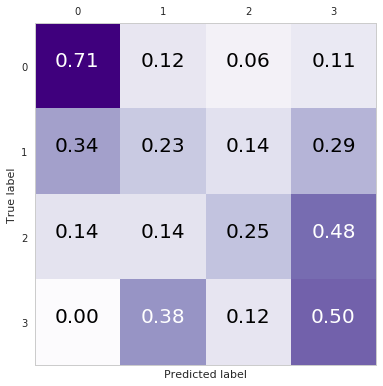

In [34]:
gnb_priors = GaussianNB()
gnb_priors, cv_results = cv(gnb_priors, param_grid_gnb, X_train, y_train, 100)
y_pred = gnb_priors.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.72


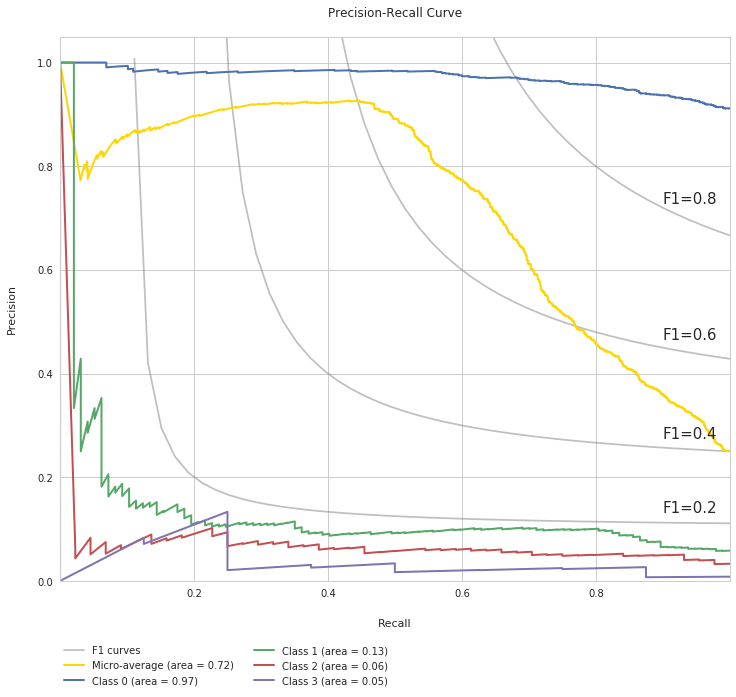

In [35]:
y_pred_gpc_c_proba = gnb_priors.predict_proba(X_test)
prec_rec_curve(y_test, y_pred_gpc_c_proba, 4, fontsize=15)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1521
           1       0.25      0.04      0.07        97
           2       0.05      0.32      0.09        44
           3       0.02      0.88      0.03         8

    accuracy                           0.58      1670
   macro avg       0.32      0.46      0.24      1670
weighted avg       0.90      0.58      0.70      1670



<Figure size 432x288 with 0 Axes>

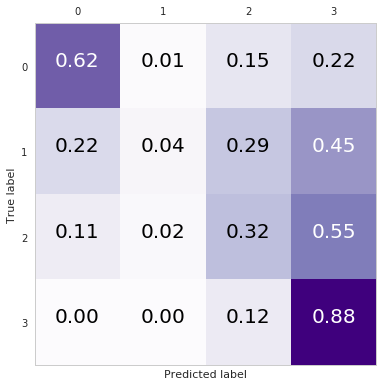

In [52]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.65


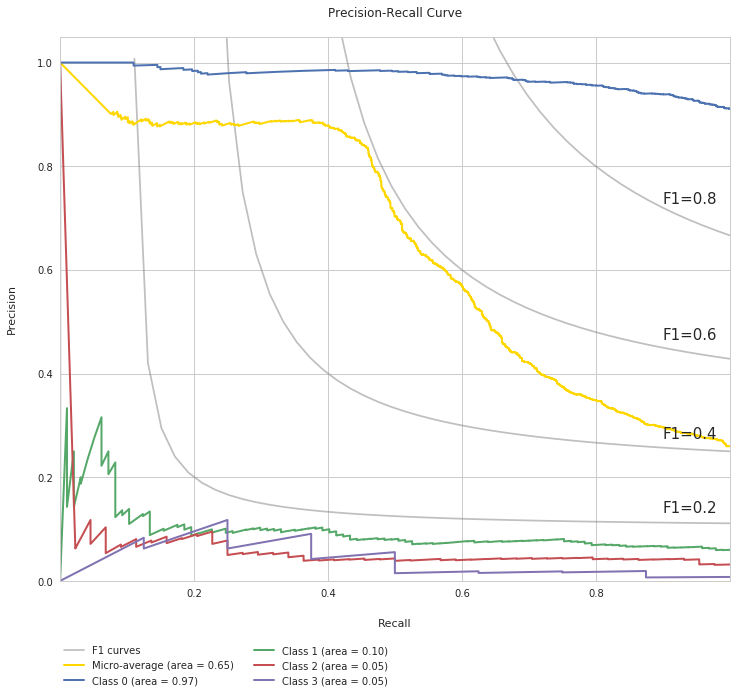

In [53]:
y_pred_proba = gnb.predict_proba(X_test)
prec_rec_curve(y_test, y_pred_proba, 4, fontsize=15)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1521
           1       0.24      0.04      0.07        97
           2       0.05      0.32      0.09        44
           3       0.02      0.88      0.03         8

    accuracy                           0.58      1670
   macro avg       0.32      0.46      0.24      1670
weighted avg       0.90      0.58      0.70      1670



### Hard wind

Train data shape: (1447, 34)
Test data shape: (1670, 34)
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1521
           1       0.11      0.38      0.17        97
           2       0.10      0.27      0.14        44
           3       0.02      0.25      0.04         8

    accuracy                           0.68      1670
   macro avg       0.30      0.40      0.29      1670
weighted avg       0.89      0.68      0.76      1670



<Figure size 432x288 with 0 Axes>

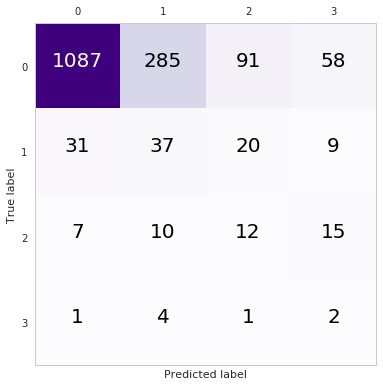

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [79]:
X_train_thin, y_train_thin, X_test, y_test = read_data('../data/loiste_jse_small_thin_train.csv', 
                                                       '../data/loiste_jse_all_test.csv', 
                                                       options_thin)

X_train_20 = X_train_thin.loc[(X_train_thin['low_limit'] > 10)]
y_train_20 = y_train_thin[(X_train_thin['low_limit'] > 10)]
gnb = GaussianNB().fit(X_train_20, y_train_20)
y_pred = gnb.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=False, cmap=plt.cm.Purples)
print(classification_report(y_test, y_pred))

## Energiateollisuus

### Get data

In [42]:
X_train_ene, y_train_ene, X_test_ene, y_test_ene = read_data('../data/energiateollisuus_all_train.csv', '../data/energiateollisuus_all_test.csv', options)

Train data shape: (84887, 58)
Test data shape: (28296, 58)


## Train

In [33]:
priors = []
for i in np.arange(0,1,.05):
    for j in np.arange(0, 1-i, .05):
        for k in np.arange(0,1-i-j, .05):
            l = 1 - i - j -k
            priors.append([i, j, k, l])
                            
param_grid_gnb = {'priors': priors+[None],
                  'var_smoothing': expon(scale=.01)}

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.45, 0.05, 0.0, 0.5], 'var_smooth...       0.090949   
1  {'priors': [0.4, 0.05, 0.25, 0.299999999999999...       0.087533   
2  {'priors': [0.7000000000000001, 0.1, 0.0, 0.19...       0.087725   
3  {'priors': [0.45, 0.0, 0.15000000000000002, 0....       0.092129   
4  {'priors': [0.65, 0.15000000000000002, 0.0, 0....       0.085965   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.001054         0.177172        0.005181              0.283048   
1      0.002479         0.166991        0.013584              0.282632   
2      0.003275         0.170104        0.005464              0.272646   
3      0.003484         0.196855        0.028707              0.276195   
4      0.004498         0.170116        0.014184              0.269752   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.282948              0.286639            0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


<Figure size 432x288 with 0 Axes>

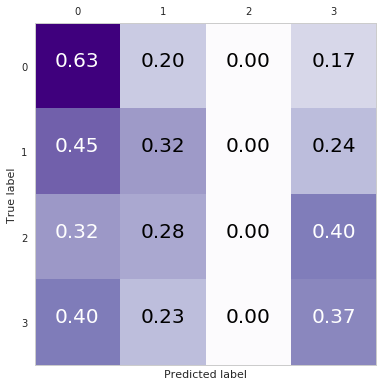

In [43]:
gnb_priors_ene = GaussianNB()
gnb_priors_ene, cv_results_ene = cv(gnb_priors_ene, param_grid_gnb, X_train_ene, y_train_ene, 100)
y_pred_ene = gnb_priors_ene.predict(X_test_ene)
plot_confusion_matrix(y_test_ene, y_pred_ene, range(0,4), normalize=True, cmap=plt.cm.Purples)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


Average precision score, micro-averaged over all classes: 0.52


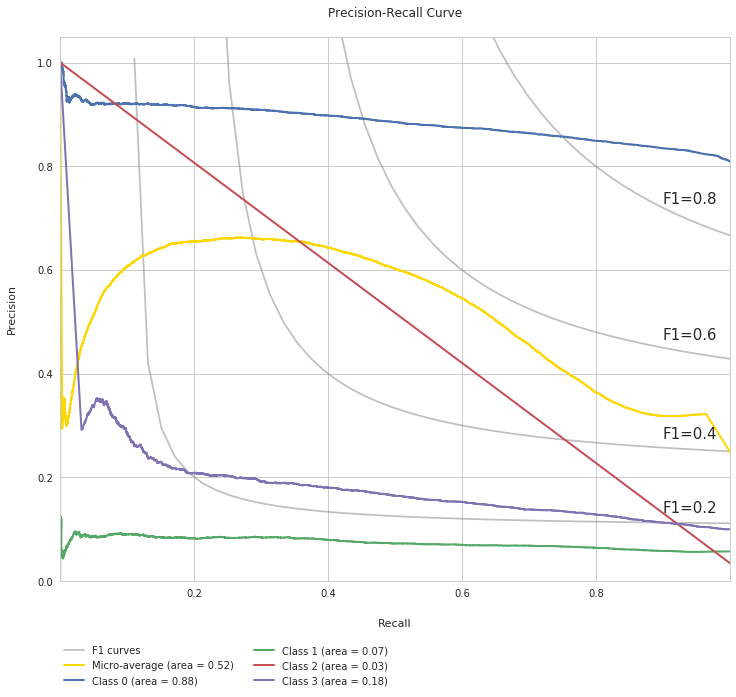

In [44]:
y_pred_ene_proba = gnb_priors_ene.predict_proba(X_test_ene)
prec_rec_curve(y_test_ene, y_pred_ene_proba, 4, fontsize=15)

In [49]:
print(classification_report(y_test_ene, y_pred_ene))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     22895
           1       0.07      0.32      0.12      1607
           2       0.00      0.00      0.00       982
           3       0.00      0.00      0.00      2812

    accuracy                           0.64     28296
   macro avg       0.23      0.27      0.23     28296
weighted avg       0.68      0.64      0.66     28296



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

<Figure size 432x288 with 0 Axes>

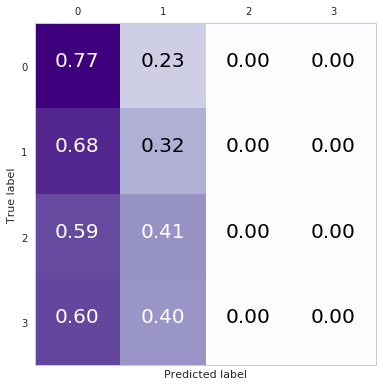

In [45]:
gnb_ene = GaussianNB().fit(X_train, y_train)
y_pred_ene = gnb.predict(X_test_ene)
plot_confusion_matrix(y_test_ene, y_pred_ene, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.60


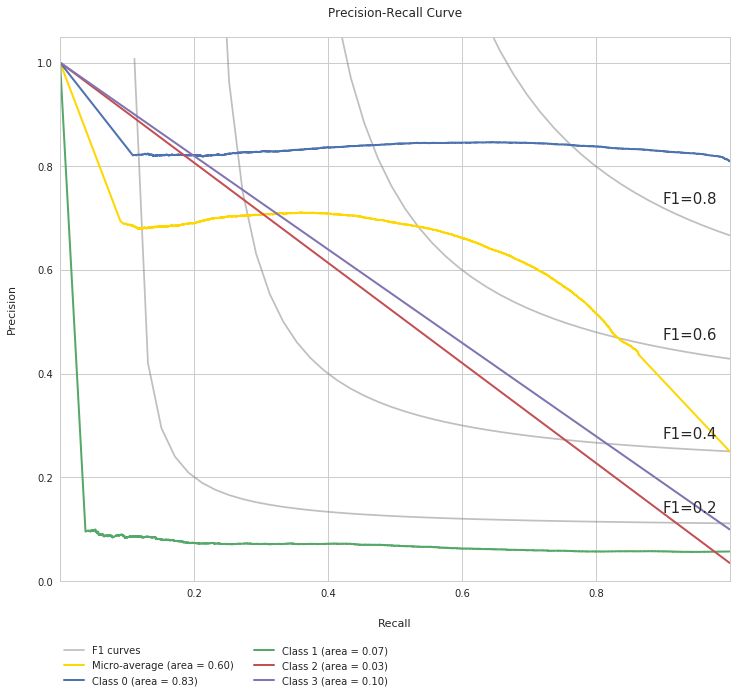

In [47]:
y_pred_proba_ene = gnb_ene.predict_proba(X_test_ene)
prec_rec_curve(y_test_ene, y_pred_proba_ene, 4, fontsize=15)

In [48]:
print(classification_report(y_test_ene, y_pred_ene))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     22895
           1       0.07      0.32      0.12      1607
           2       0.00      0.00      0.00       982
           3       0.00      0.00      0.00      2812

    accuracy                           0.64     28296
   macro avg       0.23      0.27      0.23     28296
weighted avg       0.68      0.64      0.66     28296



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,